In [25]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F

sns.set_theme(
    context="notebook",
    style="whitegrid",
    palette="deep",
    font="sans-serif",
    font_scale=2,
    color_codes=True,
    rc=None,
)

curdir = Path.cwd()
sys.path.append(str(curdir.parent))
from utils.metrics import dice_batch

## Setting up Paths

In [42]:
results_path = curdir.parent / "results"
data_path = curdir.parent / "data"

dataset = "segthor_train"  # 3D

categories = ["Background", "Esophagus", "Heart", "Trachea", "Aorta"]
K = len(categories)

experiments_path = results_path / dataset
experiments = list(experiments_path.iterdir())
print("Found experiments:")
for i, exp in enumerate(experiments):
    print(f"{i}: {exp.stem}")
    

Found experiments:
0: nnUNet_2d_DiceFocal_NoAug
1: nnUNet_2d_DiceFocal_Aug


In [46]:
def process_experiment(experiment):
    # This assumes you have a folder with results as PatientID.nii.gz   
    patients = list(filter(lambda x: ".nii.gz" in x.name, experiment.iterdir()))

    store = np.zeros((len(patients), K))
    gt_path = data_path / dataset / "train"
    for i, patient in enumerate(patients):
        patient_id = patient.stem.split(".")[0] # PatientID.nii.gz -> PatientID
        print(patient_id)
        pred = np.asarray(nib.load(patient).dataobj)
        gt = np.asarray(nib.load(gt_path / patient_id / "GT.nii.gz").dataobj)
        pred, gt = torch.from_numpy(pred), torch.from_numpy(gt)
        pred, gt = (
            F.one_hot(pred.long(), K).permute(3, 0, 1, 2),
            F.one_hot(gt.long(), K).permute(3, 0, 1, 2),
        )
        dice = dice_batch(gt.unsqueeze(0), pred.unsqueeze(0))
        store[i] = dice.cpu().numpy()
        del pred, gt
        print(dice)

    np.save(experiment / "dice_pred.npy", store)


process_experiment(experiments[0])
process_experiment(experiments[1])

Patient_10
tensor([0.9990, 0.9661, 0.9195, 0.9805, 0.9722])
Patient_02
tensor([0.9997, 0.9583, 0.9523, 0.9810, 0.9773])
Patient_34
tensor([0.9994, 0.9750, 0.9406, 0.9659, 0.9769])
Patient_38
tensor([0.9995, 0.9588, 0.9500, 0.9666, 0.9661])
Patient_26
tensor([0.9995, 0.9632, 0.9403, 0.9670, 0.9747])
Patient_12
tensor([0.9994, 0.9459, 0.9564, 0.9691, 0.9752])
Patient_24
tensor([0.9994, 0.9501, 0.9348, 0.9512, 0.9778])
Patient_36
tensor([0.9995, 0.9612, 0.9513, 0.9714, 0.9762])
Patient_28
tensor([0.9992, 0.9589, 0.9535, 0.9694, 0.9748])
Patient_32
tensor([0.9994, 0.9715, 0.9596, 0.9786, 0.9792])
Patient_20
tensor([0.9997, 0.9373, 0.9545, 0.9550, 0.9572])
Patient_16
tensor([0.9994, 0.9581, 0.9480, 0.9587, 0.9771])
Patient_08
tensor([0.9996, 0.9472, 0.9425, 0.9794, 0.9730])
Patient_04
tensor([0.9996, 0.9543, 0.9617, 0.9803, 0.9706])
Patient_22
tensor([0.9995, 0.9499, 0.9426, 0.9721, 0.9793])
Patient_30
tensor([0.9994, 0.9627, 0.9496, 0.9641, 0.9732])
Patient_18
tensor([0.9994, 0.9204, 0.971

## SegVol Results

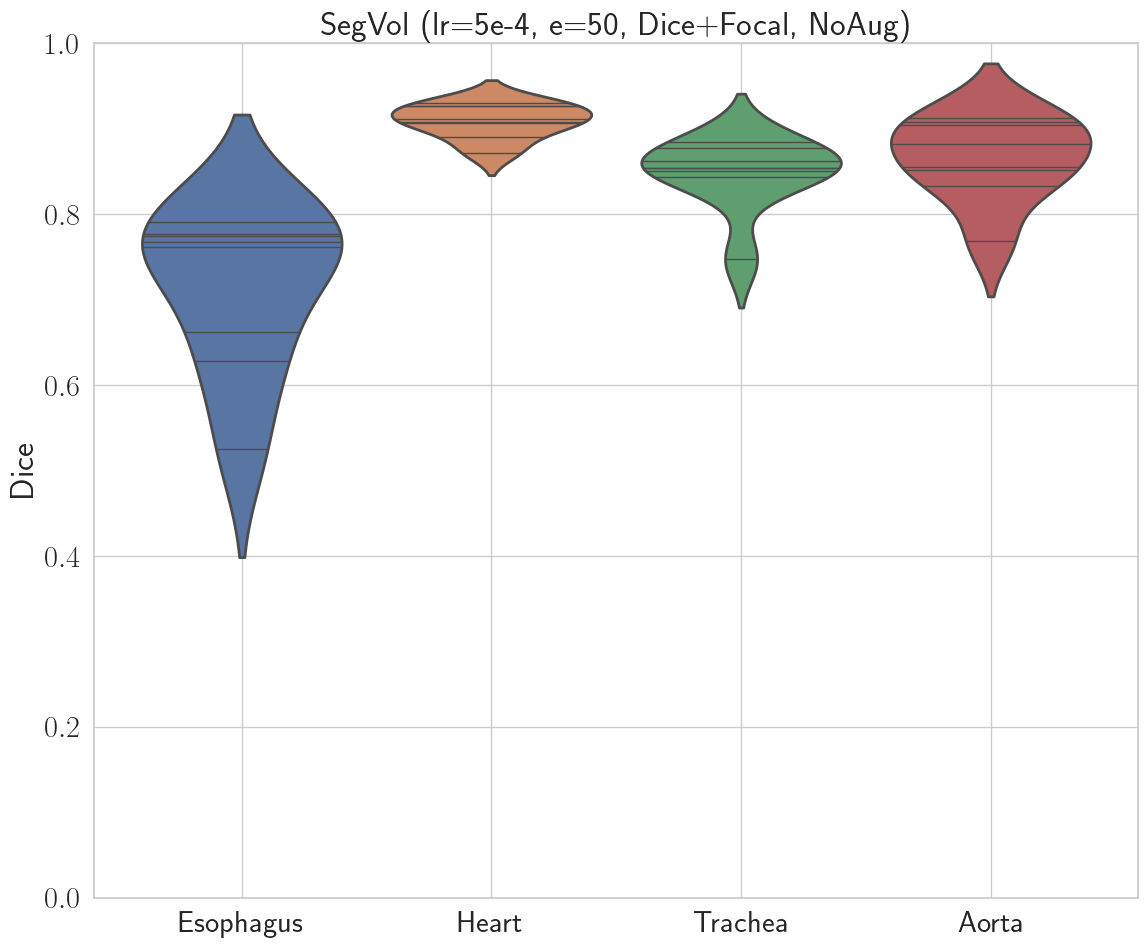

In [120]:
experiment = experiments[0]
store = np.load(experiment / "dice_pred.npy")
store = store[:, 1:] # Exclude background
sns.violinplot(
    data=store,
    density_norm="width",
    native_scale=True,
    linewidth=2,
    common_norm=False,
    inner="stick",
)
plt.ylim(0, 1)
plt.xticks(ticks=np.arange(K - 1), labels=categories[1:])
plt.ylabel("Dice")
plt.title(f"SegVol (lr=5e-4, e=50, Dice+Focal, NoAug)")
plt.tight_layout()
save_dir = curdir / experiment.stem / "dice_pred.png"
save_dir.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir, bbox_inches="tight")

## Display Violin plots side by side.

,Experiment,Category,Dice
0,Aug,Esophagus,0.773900
1,Aug,Esophagus,0.628600
2,Aug,Esophagus,0.790200
3,Aug,Esophagus,0.767100
4,Aug,Esophagus,0.661500
...,...,...,...
59,NoAug,Aorta,0.781423
60,NoAug,Aorta,0.824589
61,NoAug,Aorta,0.781207
62,NoAug,Aorta,0.847573


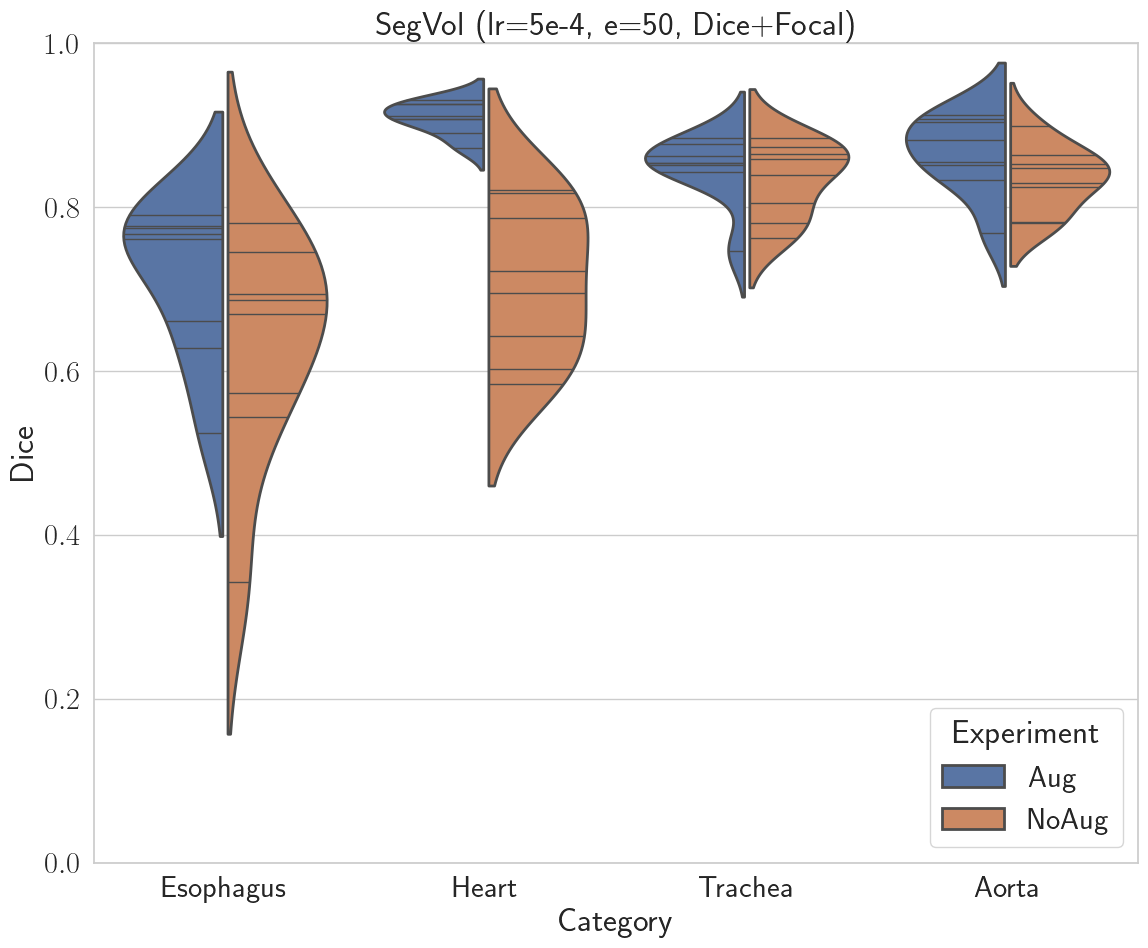

<Figure size 1200x1000 with 0 Axes>

In [121]:
store_1 = np.load(experiments[0] / "dice_pred.npy")
store_1 = store_1[:, 1:]  # Exclude background

store_2 = np.load(experiments[1] / "dice_pred.npy")
store_2 = store_2[:, 1:]  # Exclude background

df = pd.concat(
    [
        pd.DataFrame(store_1, columns=categories[1:]).assign(Experiment="Aug"),
        pd.DataFrame(store_2, columns=categories[1:]).assign(Experiment="NoAug"),
    ]
)

# Convert dataframe from wide-form to long-form
df_long = pd.melt(df, id_vars=["Experiment"], var_name="Category", value_name="Dice")
display(df_long)
# Create a violin plot
sns.violinplot(
    data=df_long,
    x="Category",
    y="Dice",
    hue="Experiment",
    density_norm="count",
    native_scale=True,
    linewidth=2,
    gap=0.05,
    common_norm=False,
    split=True,
    inner="stick",
)
plt.ylim(0, 1)
plt.ylabel("Dice")
plt.title(f"SegVol (lr=5e-4, e=50, Dice+Focal)")
plt.tight_layout()
plt.show()
save_dir = curdir / "dice_pred_aug_vs_noaug.png"
plt.savefig(save_dir, bbox_inches="tight")

## nnUNet Results

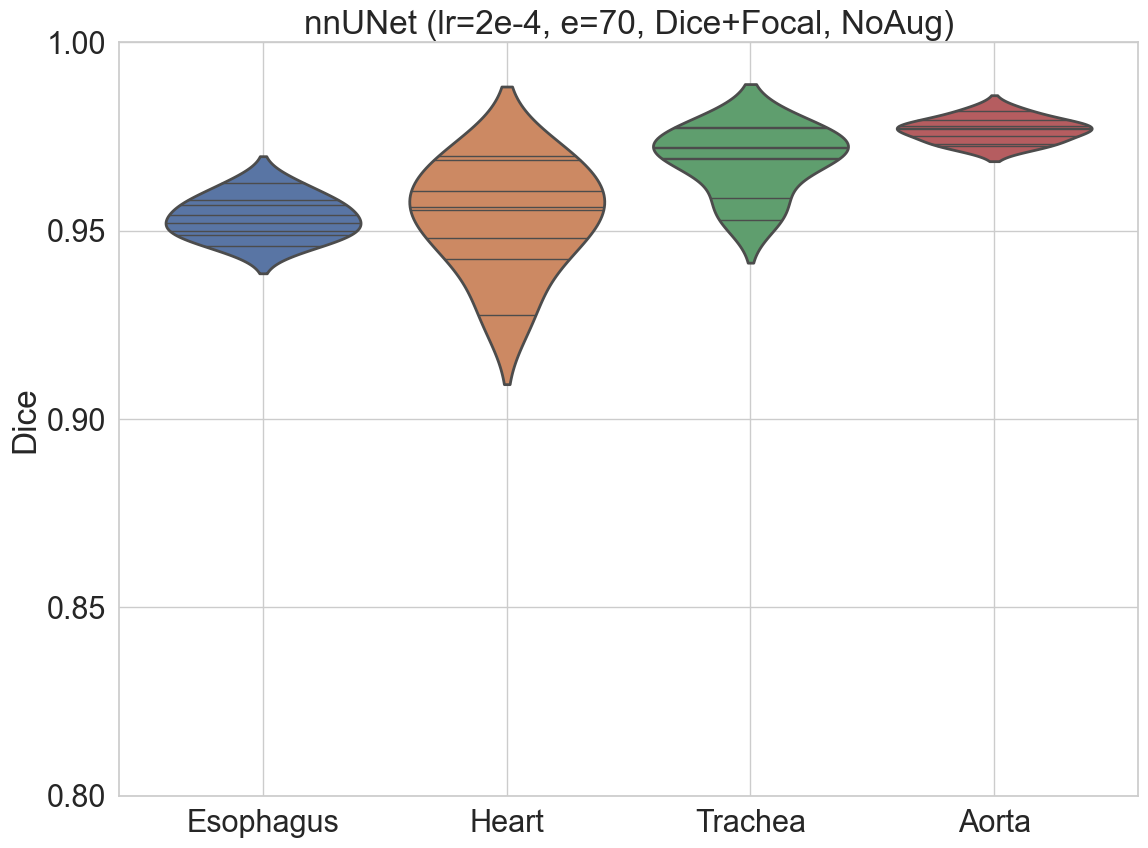

In [47]:
experiment = experiments[0]
store = np.load(experiment / "dice_pred.npy")
store = store[:, 1:] # Exclude background
store = store[np.random.choice(store.shape[0], 8, replace=False)]


plt.figure(figsize=(12, 9)) 

sns.violinplot(
    data=store,
    density_norm="width",
    native_scale=True,
    linewidth=2,
    common_norm=False,
    inner="stick",
)
plt.ylim(0.8, 1)
plt.yticks([0.8, 0.85, 0.9, 0.95, 1])
plt.xticks(ticks=np.arange(K - 1), labels=categories[1:])
plt.ylabel("Dice")
plt.title(f"nnUNet (lr=2e-4, e=70, Dice+Focal, NoAug)")
plt.tight_layout()
save_dir = curdir / experiment.stem / "dice_pred.png"
save_dir.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir, bbox_inches="tight")

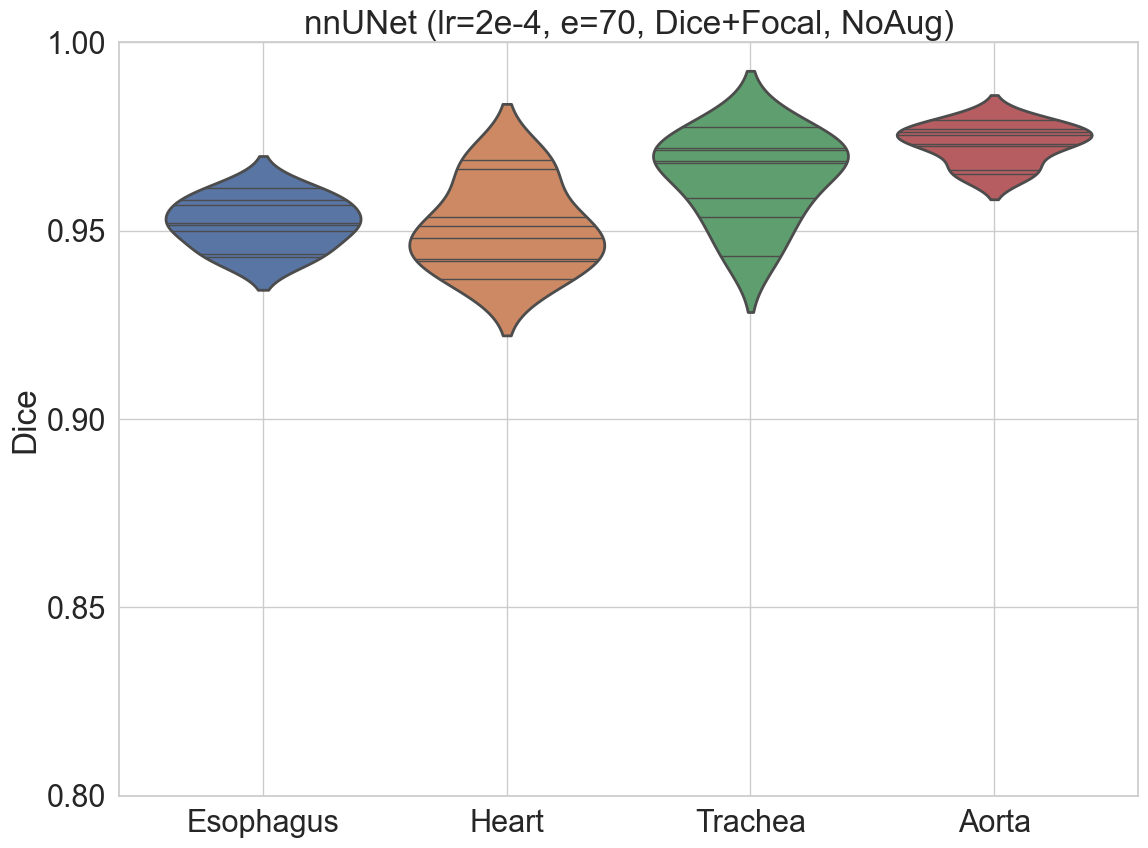

In [48]:
experiment = experiments[1]
store = np.load(experiment / "dice_pred.npy")
store = store[:, 1:] # Exclude background
store = store[np.random.choice(store.shape[0], 8, replace=False)]


plt.figure(figsize=(12, 9)) 

sns.violinplot(
    data=store,
    density_norm="width",
    native_scale=True,
    linewidth=2,
    common_norm=False,
    inner="stick",
)
plt.ylim(0.8, 1)
plt.yticks([0.8, 0.85, 0.9, 0.95, 1])
plt.xticks(ticks=np.arange(K - 1), labels=categories[1:])
plt.ylabel("Dice")
plt.title(f"nnUNet (lr=2e-4, e=70, Dice+Focal, NoAug)")
plt.tight_layout()
save_dir = curdir / experiment.stem / "dice_pred.png"
save_dir.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir, bbox_inches="tight")

,Experiment,Category,Dice
0,Aug,Esophagus,0.961229
1,Aug,Esophagus,0.960166
2,Aug,Esophagus,0.963189
3,Aug,Esophagus,0.958831
4,Aug,Esophagus,0.958853
...,...,...,...
59,NoAug,Aorta,0.972188
60,NoAug,Aorta,0.969884
61,NoAug,Aorta,0.972594
62,NoAug,Aorta,0.975419


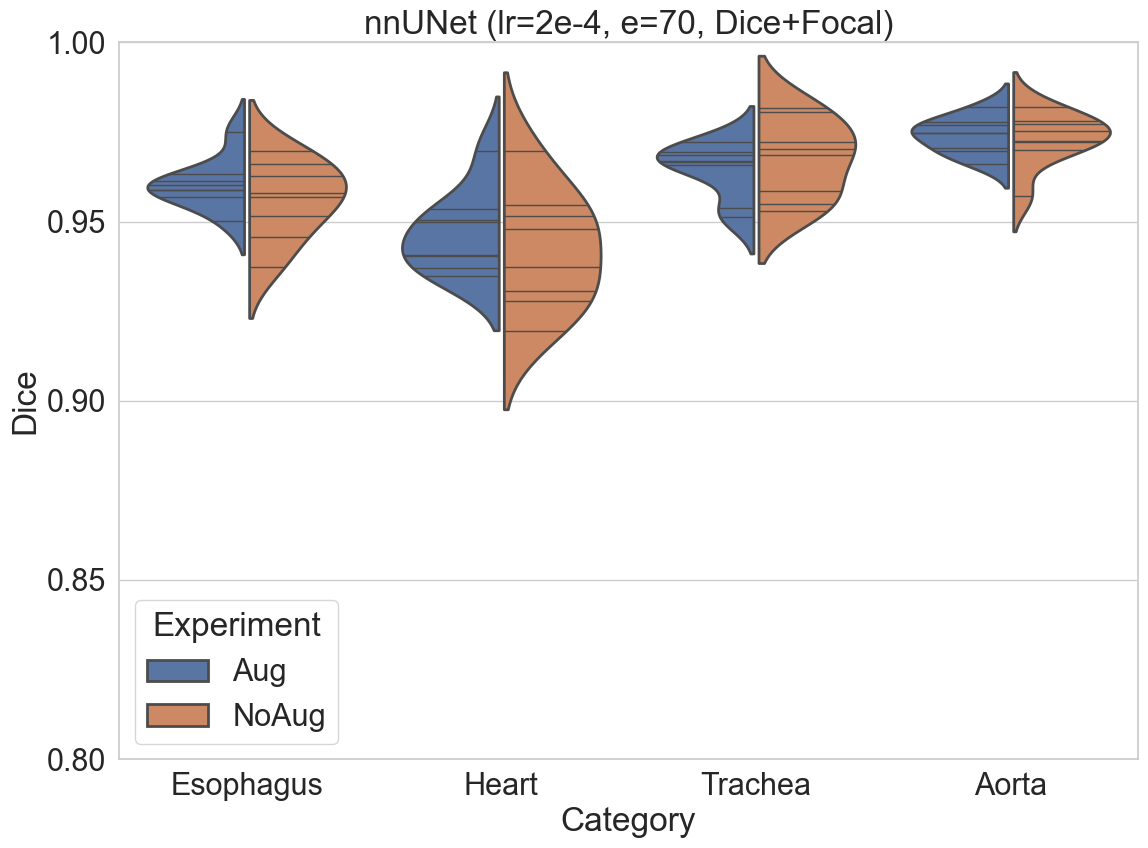

In [60]:
store_1 = np.load(experiments[0] / "dice_pred.npy")
store_1 = store_1[:, 1:]  # Exclude background
store_1 = store_1[np.random.choice(store_1.shape[0], 8, replace=False)]

store_2 = np.load(experiments[1] / "dice_pred.npy")
store_2 = store_2[:, 1:]  # Exclude background
store_2 = store_2[np.random.choice(store_2.shape[0], 8, replace=False)]

df = pd.concat(
    [
        pd.DataFrame(store_1, columns=categories[1:]).assign(Experiment="Aug"),
        pd.DataFrame(store_2, columns=categories[1:]).assign(Experiment="NoAug"),
    ]
)

# Convert dataframe from wide-form to long-form
df_long = pd.melt(df, id_vars=["Experiment"], var_name="Category", value_name="Dice")
display(df_long)

plt.figure(figsize=(12, 9)) 

# Create a violin plot
sns.violinplot(
    data=df_long,
    x="Category",
    y="Dice",
    hue="Experiment",
    density_norm="count",
    native_scale=True,
    linewidth=2,
    gap=0.05,
    common_norm=False,
    split=True,
    inner="stick",
)
plt.ylim(0.8, 1)
plt.yticks([0.8, 0.85, 0.9, 0.95, 1])
plt.ylabel("Dice")
plt.title(f"nnUNet (lr=2e-4, e=70, Dice+Focal)")
plt.tight_layout()
save_dir = curdir /"nnUNet_2d_DiceFocal_comparison" /"dice_pred_aug_vs_noaug.png"
save_dir.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir, bbox_inches="tight")
plt.show()